# Etude et simulation du modèle de Black-Scholes

Posons le modèle de Black-Scholes : 

$dS_t = rS_t dt + \sigma S_t dW_t $

Nous avons l'approximation d'**Euler-Maruyama** :

$S_{t+\Delta t} =S_t + r S_t dt + \sigma S_t \sqrt{dt} Z$

Avec  $Z \sim \mathcal{N}(0,1)$

Voici la modélisation des trajectoires avec ce modèle sous Python :

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sk

In [34]:
S0 = 1000
r = 0.9
sigma = 0.9
T = 1
N = 365
M = 100
dt = T/N

S = np.zeros((M, N+1))
S[:,0]=S0

for t in range(1, N+1):
    Z = np.random.standard_normal(M)
    S[:, t] = S[:, t-1] + r * S[:, t-1]*dt + sigma * S[:, t-1] * np.sqrt(dt) * Z

In [35]:
ST = S[:, -1]
K = 1100

call_price= np.exp(-r*T)*np.mean(np.maximum(ST-K, 0))
put_price = np.exp(-r*T)*np.mean(np.maximum(K-ST, 0))
diff = call_price - put_price
print(f"Le prix d'un call approximé numériquement est : {call_price}")
print(f"Le prix d'un put approximé numériquement est : {put_price}")
print(f"La différence call-put est : {diff} ")

Le prix d'un call approximé numériquement est : 564.8889156492255
Le prix d'un put approximé numériquement est : 54.90878296685217
La différence call-put est : 509.9801326823733 


## La représentation graphique de 100 trajectoires simulées par le modèle de Black-Scholes

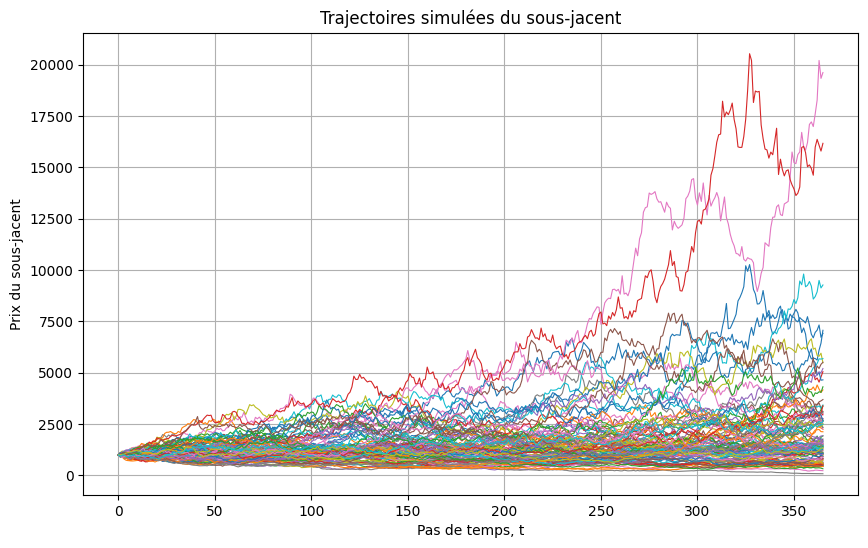

In [36]:
plt.figure(figsize=(10,6))
for i in range(M):
    plt.plot(S[i], lw = 0.8)
plt.title("Trajectoires simulées du sous-jacent")
plt.xlabel("Pas de temps, t")
plt.ylabel("Prix du sous-jacent")
plt.grid(True)
plt.show()

Visualisons la **moyenne de toutes les trajectoires**

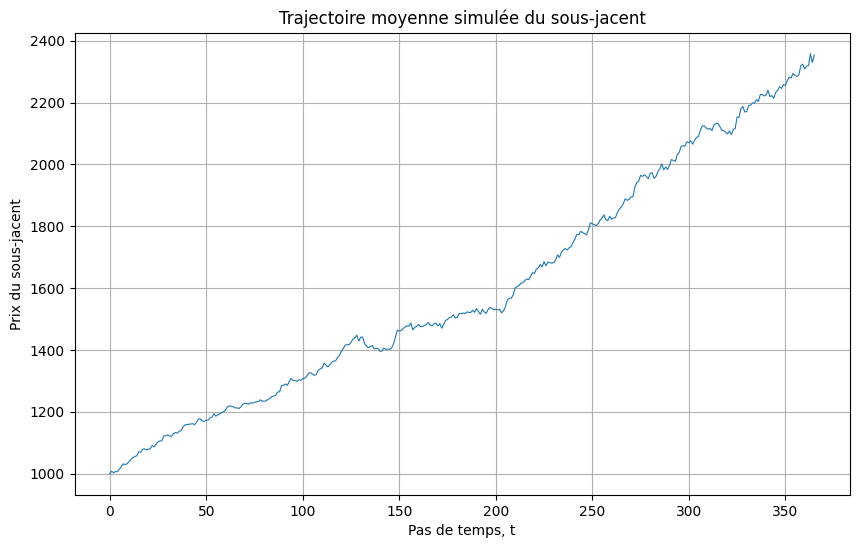

In [37]:
plt.figure(figsize=(10,6))
plt.plot(np.mean(S, axis=0), lw = 0.8)
plt.title("Trajectoire moyenne simulée du sous-jacent")
plt.xlabel("Pas de temps, t")
plt.ylabel("Prix du sous-jacent")
plt.grid(True)
plt.show()

## Visualisation des prix call/put en fonction de volatilité $\sigma$, $T$ et le taux sans risque $r$

Le prix analytique d'un call/put européen est : 

Posons $d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(r + \frac{1}{2}\sigma^2\right)T}{\sigma \sqrt{T}}$ et $d_2 = d_1 - \sigma \sqrt{T}$

$C(S_0, K, T, r, \sigma)= S_0\Phi(d_1) - Ke^{-rT}\Phi(d_2)$

$P(S_0, K, T, r, \sigma) = Ke^{-rT}\Phi(-d_2) - S_0\Phi(-d_1)$

### Visualisons les prix en fonction de la volatilité ($\sigma$)

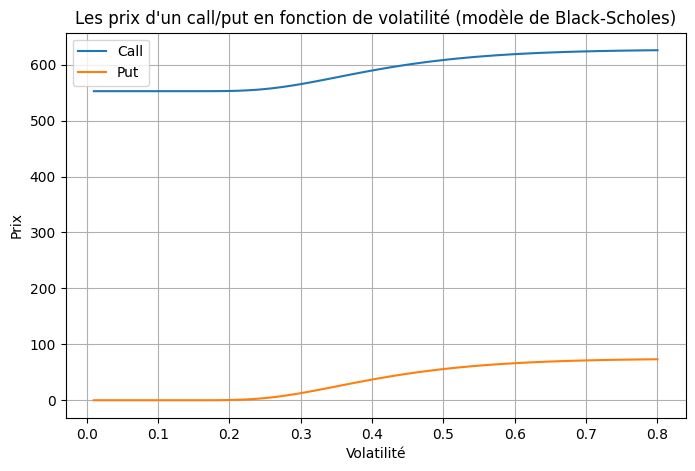

In [56]:
def b_s_call(S,K,T,r,s):
    d1=(np.log(S/K) + (r + 0.5 * s**2)*T)/ (s * np.sqrt(T))
    d2 = d1 - np.sqrt(T)
    return S*sk.norm.cdf(d1) - K * np.exp(-r*T) * sk.norm.cdf(d2)

def b_s_put(S,K,T,r,s):
    d1=(np.log(S/K) + (r + 0.5 * s**2)*T)/ (s* np.sqrt(T))
    d2 = d1 - np.sqrt(T)
    return -S*sk.norm.cdf(-d1) + K * np.exp(-r*T) * sk.norm.cdf(-d2)

s= np.linspace(0.01, 0.8, 100)
call_prices_sigma = [b_s_call(S0, K, T, r, s) for s in s ]
put_prices_sigma = [b_s_put(S0, K, T, r, s) for s in s ]

plt.figure(figsize=(8,5))
plt.plot(s, call_prices_sigma, label="Call")
plt.title("Les prix d'un call/put en fonction de volatilité (modèle de Black-Scholes)")
plt.plot(s, put_prices_sigma, label="Put")
plt.xlabel("Volatilité")
plt.ylabel("Prix")
plt.grid(True)
plt.legend()
plt.show()

Nous constatons que **les prix d'un call et d'un put augmentent avec la volatilité**